# Проект 4. Компьютер говорит 'Нет'

# 1. Подключаем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
%matplotlib inline

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


# 2. Определяем классы и функции

In [2]:
class LogDf(): # класс логарифмирования признака
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 

class NumFitInspect(): # класс для построения визуализация для числового признака и нахождения выбросов.
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False): # графики
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))

        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax1) # сравнение с нормальным распределением
        fig.suptitle('QQ-plot, histogram and boxplot for {0} '.format(column))
        
        ax2.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'green') # гистограмма
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def boundaries(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def outliers(self, log = False): # общее количество выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.boundaries(log)
        return len(data[data < minb])+ len(data[data > maxb])


In [3]:
class ModelInspect(): # класс для оценки метрик модели
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
    
    def confusion_matrix_plot(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure()
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'Pastel1', cbar = False, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок для default')
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure()
        
        plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lime')
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
        plt.grid(True)

        plt.show()
                                          


# 3. Импортируем данные

In [4]:
data_directory = '/kaggle/input/sf-dst-scoring/'
data_train = pd.read_csv(data_directory+'train.csv')
data_test = pd.read_csv(data_directory+'test.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

In [5]:
# зафиксируем константы
!pip freeze > requirements.txt
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

In [6]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
data_train['Train'] = 1 # помечаем где у нас трейн
data_test['Train'] = 0 # помечаем где у нас тест

data = data_train.append(data_test, sort=False).reset_index(drop=True) # объединяем

In [7]:
print('размерность тренировочного датасета: ', data_train.shape, '\n')
print('размерность тестовго датасета: ', data_test.shape)

размерность тренировочного датасета:  (73799, 20) 

размерность тестовго датасета:  (36349, 19)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

В тренировочном наборе 73799 записей, в тестовой - 36349. Всего 19 переменных (18 признаков + целевая).

# 4. Выполняем предварительный анализ данных

In [9]:
data.sample(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
88997      51301  28FEB2014       SCH   F   23   N        N                1   
3482       83766  31MAR2014       GRD   M   37   Y        Y                0   
81389      75472  23MAR2014       SCH   F   60   N        N                0   
36616      29659  05FEB2014       GRD   F   61   N        N                0   
89122      62217  11MAR2014       GRD   F   44   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
88997          0  -1.647599                3             40             1   
3482           1  -1.593437                0             80             2   
81389          0  -1.850777                0             50             2   
36616          0  -1.994682                3             50             1   
89122          0  -2.770360                0             80             2   

       work_address  income  sna  first_time foreign_passport  default  Train  
88997             1   10000    1           1                N      NaN      0  
3482              3   60000    1           2                N      0.0      1  
81389             3   12000    4           1                N      NaN      0  
36616             1   41000    1           3                N      0.0      1  
89122             3  140000    2           3                N      NaN      0

In [10]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

В поле education имеются пропуски. <br>
Пропуски в default - у тестовой выборки, их нужно предсказать. <br>
default - целевая переменная.

In [11]:
data.describe(include = 'object')

app_date education     sex     car car_type foreign_passport
count      110148    109670  110148  110148   110148           110148
unique        120         5       2       2        2                2
top     18MAR2014       SCH       F       N        N                N
freq         1491     57998   61836   74290    89140            93721

In [12]:
# посмотрим на значения в строковых полях
cols = data.columns
for col in cols:
    if data[col].dtype == 'O':
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))

Уникальные значения в поле app_date : ['01FEB2014' '12MAR2014' '23JAN2014' '18APR2014' '18FEB2014' '04FEB2014'
 '17MAR2014' '14FEB2014' '10JAN2014' '03FEB2014' '08APR2014' '08JAN2014'
 '19MAR2014' '22JAN2014' '30JAN2014' '11MAR2014' '02FEB2014' '14APR2014'
 '06JAN2014' '24MAR2014' '15APR2014' '28FEB2014' '11FEB2014' '30MAR2014'
 '23MAR2014' '09MAR2014' '02MAR2014' '31JAN2014' '14MAR2014' '26JAN2014'
 '03APR2014' '22MAR2014' '11JAN2014' '17FEB2014' '13FEB2014' '17APR2014'
 '25FEB2014' '10APR2014' '01APR2014' '21APR2014' '20MAR2014' '03MAR2014'
 '25MAR2014' '24FEB2014' '16APR2014' '27FEB2014' '18MAR2014' '19FEB2014'
 '20FEB2014' '31MAR2014' '04MAR2014' '25JAN2014' '07JAN2014' '07MAR2014'
 '26MAR2014' '05FEB2014' '06MAR2014' '08FEB2014' '21JAN2014' '13MAR2014'
 '09JAN2014' '07FEB2014' '29JAN2014' '27JAN2014' '15FEB2014' '29APR2014'
 '04APR2014' '16JAN2014' '07APR2014' '13JAN2014' '21MAR2014' '24JAN2014'
 '27MAR2014' '09FEB2014' '06FEB2014' '22FEB2014' '28JAN2014' '28APR2014'
 '10FEB2014' 

Мусора в строковых данных нет. <br>
В поле education нужно заполнить или удалить пропуски. <br>
Поле app_date содержит дату. Как есть, его использовать нельзя. Сконструируем на его основе новые признаки.

In [13]:
# Выпишем категориальные и бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']
cat_cols = ['education']

### 4.1. Заполним пропуски в education

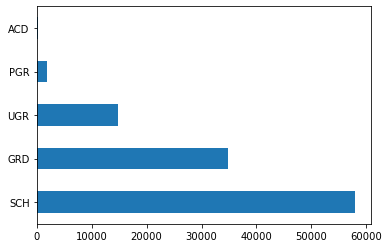

In [14]:
data.education.value_counts().plot.barh()

In [15]:
mode = data.education.mode()[0]
print('Самое частое значение в поле Education: ', mode)

Самое частое значение в поле Education:  SCH


In [16]:
# Заполним пропуски в education модой

data['education'].fillna(mode, inplace=True)
data.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'], dtype=object)

In [17]:
# Проверим
data.education.value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

### 4.2. Обработаем app_date

In [18]:
data['app_date'] = pd.to_datetime(data.app_date, format='%d%b%Y')
data['app_date'].sample(5)

18781   2014-04-13
57294   2014-04-19
26893   2014-04-08
4242    2014-03-06
64358   2014-04-17
Name: app_date, dtype: datetime64[ns]

In [19]:
data['app_date'].dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

Все заявки из датасета поданы в 2014 году.

In [20]:
data['app_date'].dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

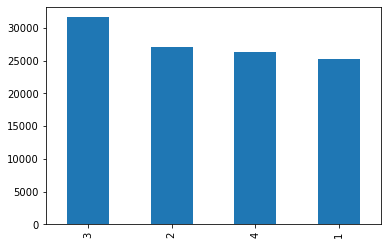

In [21]:
data['app_date'].dt.month.value_counts().plot.bar()

Все заявки приблизительно равномерно распределены между 4 месяцами.

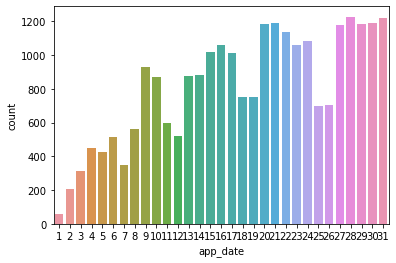

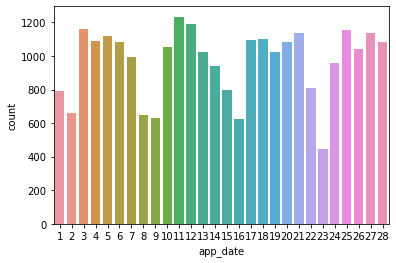

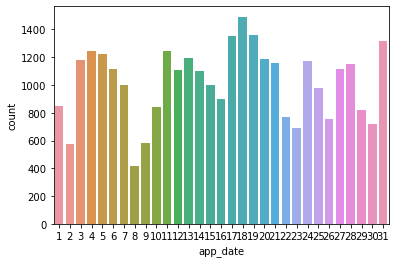

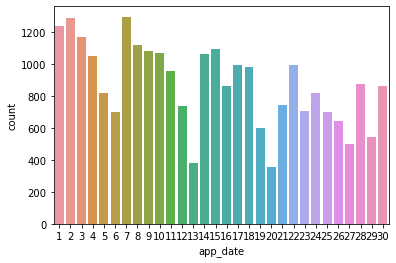

In [22]:
data['month'] = data['app_date'].dt.month
for i in [1,2,3,4]:
    plt.figure()
    sns.countplot(x=data[data.month == i]['app_date'].dt.day, data=data[data.month == i])
    plt.show()

Заявки по дням месяцев распределены приблизительно равномерно. Сильных перекосов нет.

Создадим новую переменную - количество дней от 01.01.2014.

In [23]:
NY = pd.to_datetime('01/01/2014')
NY

Timestamp('2014-01-01 00:00:00')

In [24]:
data['days_from_ny'] = (data['app_date'] - NY).dt.days
data[data.month == 1]['days_from_ny'].sample(5)

64852    16
56766    27
84522    10
33873    26
2495     20
Name: days_from_ny, dtype: int64

In [25]:
# и еще один признак: количество заявок в данном дне
dates = data.app_date.value_counts()
data['app_cnt'] = data.app_date.apply(lambda x: dates[x])
data['app_cnt'].sample(5)

32738     1168
95573     1059
1933       865
106029    1189
61670      981
Name: app_cnt, dtype: int64

Итак, мы сконструировали новые признаки на основании app_data:
- month - месяц заявки
- days_from_ny - количество дней от 01.01.2014
- app_cnt - количество заявок в данном дне


Посмотрим на линейную зависимость между этими признаками

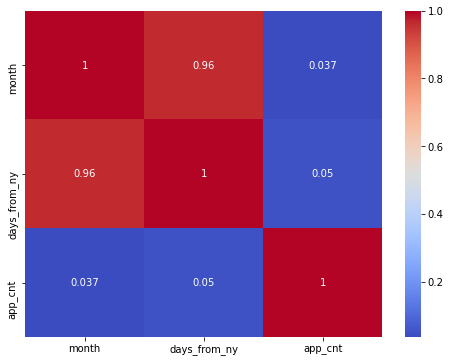

In [26]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data.loc[:,['month', 'days_from_ny', 'app_cnt']].corr(),annot = True, cmap = 'coolwarm')

Признаки month и days_from_ny очень сильно линейно-зависимы, поэтому один из них, month, мы использовать не будем.

In [27]:
# Удалим из датасета признак app_date
data.drop(['app_date', 'month'],  axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

### 4.3. Обработаем числовые признаки

In [28]:
# посмотрим на числовые признаки
# проверим, есть ли среди них категориальные
cols = data.columns
for col in cols:
    if data[col].dtype != 'O' and len(data[col].unique())<=20:
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))

Уникальные значения в поле good_work : [0 1]
Уникальные значения в поле region_rating : [50 80 60 40 70 20 30]
Уникальные значения в поле home_address : [1 2 3]
Уникальные значения в поле work_address : [2 3 1]
Уникальные значения в поле sna : [4 1 2 3]
Уникальные значения в поле first_time : [1 4 3 2]
Уникальные значения в поле default : [ 0.  1. nan]
Уникальные значения в поле Train : [1 0]


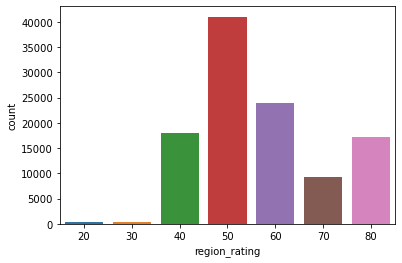

In [29]:
sns.countplot(x=data['region_rating'], data=data)

Признак region_rating похож скорее на категориальный, чем на числовой. Обработаем его как категориальный.

In [30]:
# Дополним бинарные и категориальные признаки
cat_cols += ['region_rating', 'home_address', 'work_address', 'sna', 'first_time']
bin_cols += ['good_work']

In [31]:
# Посмотрим на признак client_id
data.client_id.astype('object').describe(include = 'object')

count     110148
unique    110148
top       110148
freq           1
Name: client_id, dtype: int64

Поле client_id - уникальный идентификатор клиента, не повторяется. Смысловой нагрузки не несет, можно выбросить из датасета.

In [32]:
data.drop(['client_id'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  object 
 1   sex               110148 non-null  object 
 2   age               110148 non-null  int64  
 3   car               110148 non-null  object 
 4   car_type          110148 non-null  object 
 5   decline_app_cnt   110148 non-null  int64  
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  int64  
 9   region_rating     110148 non-null  int64  
 10  home_address      110148 non-null  int64  
 11  work_address      110148 non-null  int64  
 12  income            110148 non-null  int64  
 13  sna               110148 non-null  int64  
 14  first_time        110148 non-null  int64  
 15  foreign_passport  110148 non-null  object 
 16  default           73

In [33]:
print('Бинарные признаки: ',bin_cols)
print('Категориальные признаки :',cat_cols)

Бинарные признаки:  ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
Категориальные признаки : ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']


In [34]:
# Выпишем числовые признаки

num_cols = list(set(data.columns) - set(bin_cols + cat_cols + ['default', 'Train']))
print('Числовые признаки: ', num_cols)

Числовые признаки:  ['bki_request_cnt', 'days_from_ny', 'age', 'decline_app_cnt', 'income', 'score_bki', 'app_cnt']


#### 4.3.1. age

In [35]:
# Построим графики для age
data_age = NumFitInspect(data[data.Train == 1], 'age')

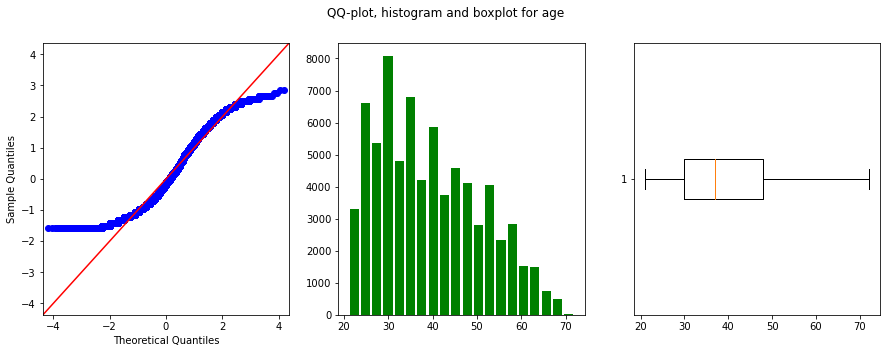

In [36]:
data_age.show_plots()

Признак распределен нормально, выбросов нет.

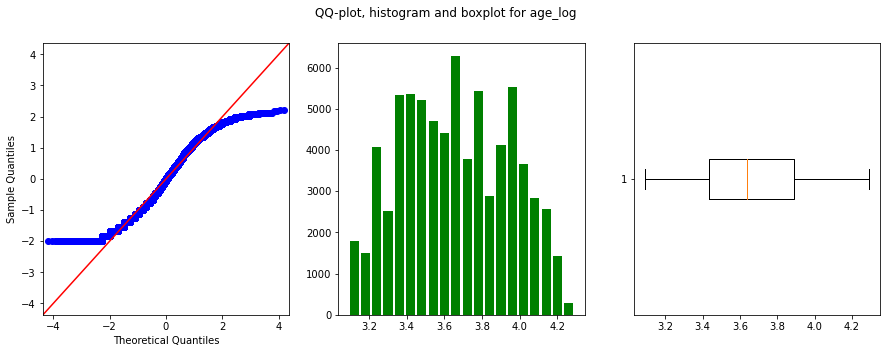

In [37]:
# посмотрим на графики  log(age) 
data_age.show_plots(log = True)

После логарифмирования  признак age стал менее смещёнными. 

In [38]:
# логарифмируем признак age
data['age'] = np.log(data['age'] + 1)
data['age'].sample(5)

32657     3.465736
62046     3.178054
38606     3.332205
105783    3.332205
109776    3.912023
Name: age, dtype: float64

***Заключение для age***: распределение нормальное, выбросов нет, взяли логарифм от признака

#### 4.3.2. decline_app_cnt

In [39]:
# Построим графики для decline_app_cnt
data_decline_app_cnt = NumFitInspect(data[data.Train == 1], 'decline_app_cnt')

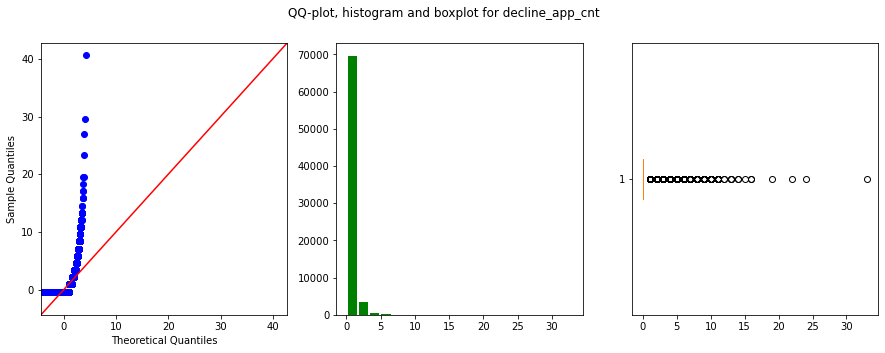

In [40]:
data_decline_app_cnt.show_plots()

Мы наблюдаем сильное смещение. Применим логарифмирование и посмотрим, что получилось

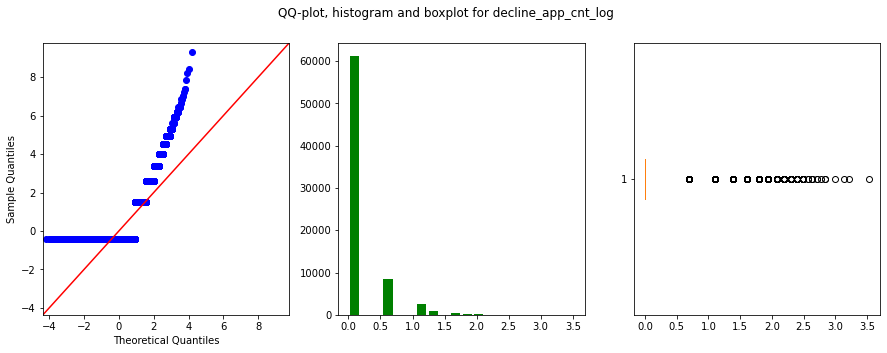

In [41]:
data_decline_app_cnt.show_plots(log = True)

Очевидно, признак стал более нормальным. <br>
Посмотрим на выбросы.

In [42]:
print('Суммарное количество выбросов для decline_app_cnt: ', data_decline_app_cnt.outliers())
print('Суммарное количество выбросов для log(decline_app_cnt): ', data_decline_app_cnt.outliers(log = True))

Суммарное количество выбросов для decline_app_cnt:  12585
Суммарное количество выбросов для log(decline_app_cnt):  12585


In [43]:
data[data.decline_app_cnt < 2].decline_app_cnt.value_counts()

0    91471
1    12500
Name: decline_app_cnt, dtype: int64

Создадим на основании decline_app_cnt новый признак:
- бинарный: было или не было отказов

In [44]:
data['decline_flag'] = data.decline_app_cnt.apply(lambda x: 0 if x < 1 else 1)
data['decline_flag'].value_counts()

0    91471
1    18677
Name: decline_flag, dtype: int64

In [45]:
new_fits = ['decline_flag']

In [46]:
# логарифмируем признак decline_app_cnt
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['decline_app_cnt'].sample(5)

14815    0.000000
41892    0.000000
57642    0.693147
83636    0.000000
5488     0.000000
Name: decline_app_cnt, dtype: float64

***Заключение по decline_app_cnt*** : распределение нормальное, очень сильно смещенное (так, что даже логарифмирование это не особо исправило), взяли логарифм, выбросов очень много даже после логарифмирования, поэтому удалять их пока не будем. Посмотрим влияение выбросов на модель в дальнейшем. <br>
Создали на его основе новый признак.

4.3.3. income

In [47]:
# Построим графики для income
data_income = NumFitInspect(data[data.Train == 1], 'income')

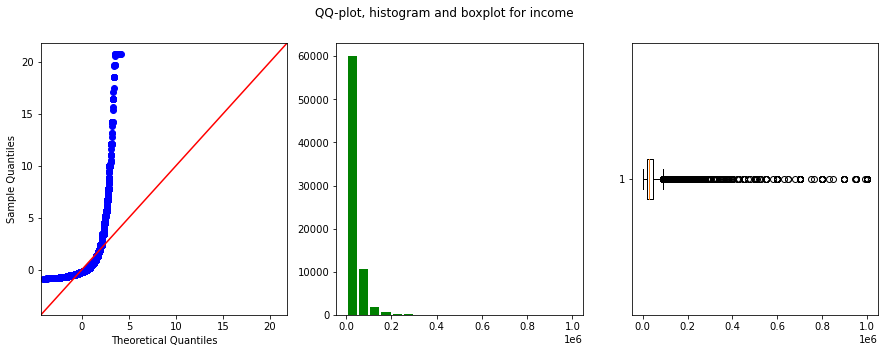

In [48]:
data_income.show_plots()

Признак очень смещен. Много выбросов. <br> Посмотрим на log(income)

Посмотрим на распределение признака по региону

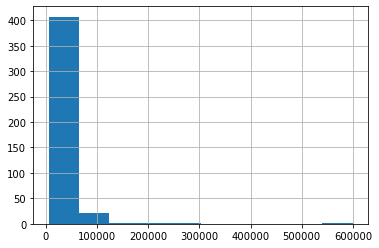

In [49]:
data['income'][data['region_rating'] == 30].hist()

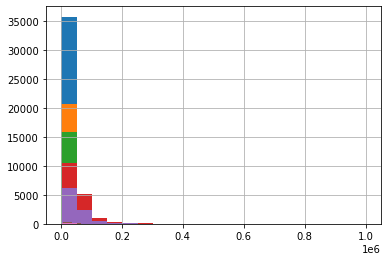

In [50]:
# посмотрим на распределение признака в регионах
for x in data['region_rating'].value_counts().index:
    data['income'][data['region_rating'] == x].hist(bins=20)
plt.show()

В регионах также наблюдается очень сильное смещение. Нормировать относительно региона не получится.

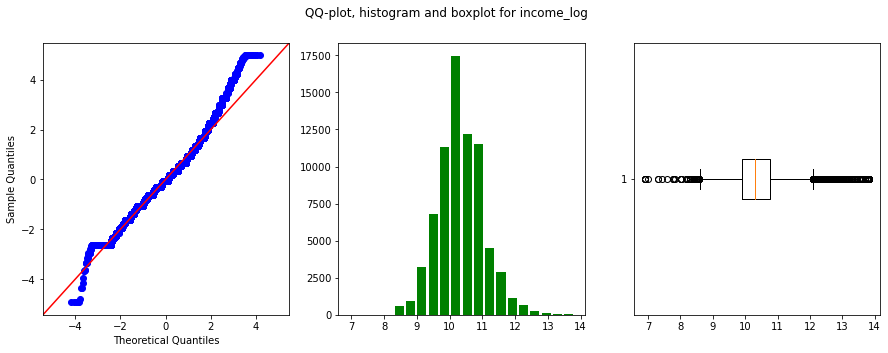

In [51]:
data_income.show_plots(log = True)

После логарифмирования признак income стал гораздо более нормальным и менее смещёнными. <br>
Посмотрим на выбросы.

In [52]:
print('Суммарное количество выбросов для income: ', data_income.outliers())
print('Суммарное количество выбросов для log(income): ', data_income.outliers(log = True))

Суммарное количество выбросов для income:  4695
Суммарное количество выбросов для log(income):  1767


После логарифмирования количество выбросов значительно уменьшилось.

In [53]:
# логарифмируем признак income
data['income'] = np.log(data['income'] + 1)
data['income'].sample(5)

55500     10.275086
86805     10.463132
93694     10.463132
107068    10.126671
74999     11.238502
Name: income, dtype: float64

***Заключение по income*** : распределение нормальное, взяли логарифм, количество выбросов после логарифмирования уменьшилось, поэтому удалять их пока не будем. Посмотрим влияение выбросов на модель в дальнейшем.

4.3.4. days_from_ny

In [54]:
# Построим графики для income
data_days_from_ny = NumFitInspect(data[data.Train == 1], 'days_from_ny')

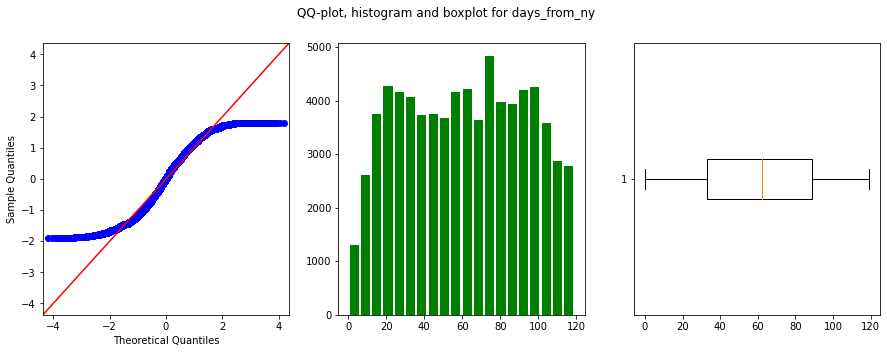

In [55]:
data_days_from_ny.show_plots()

***Заключение по days_from_ny*** : признак распределен нормально. Выбросов нет. Логарифмировать не нужно.

4.3.5. bki_request_cnt

In [56]:
# Построим графики для bki_request_cnt
data_bki_request_cnt = NumFitInspect(data[data.Train == 1], 'bki_request_cnt')

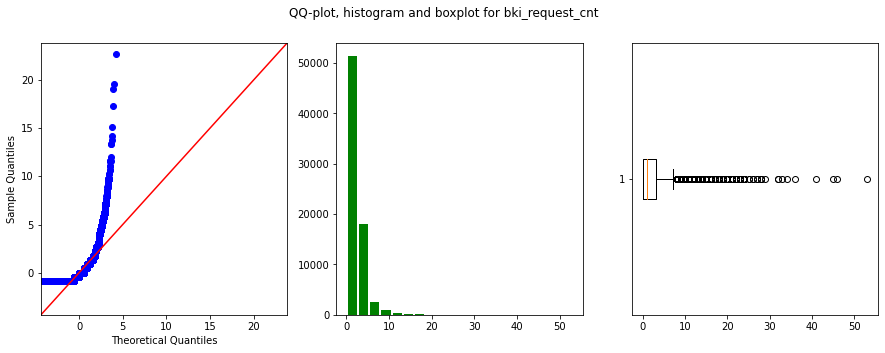

In [57]:
data_bki_request_cnt.show_plots()

Признак очень смещен. Много выбросов. <br>
Логарифмируем признак.

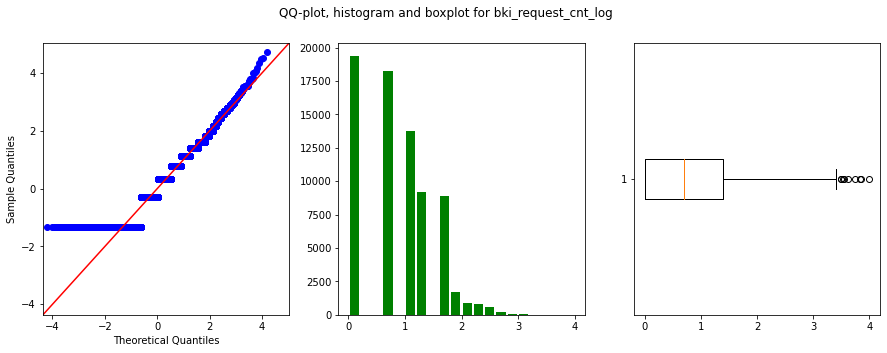

In [58]:
data_bki_request_cnt.show_plots(log = True)

Очевидно, признак стал более нормальным. <br>
Посмотрим на выбросы.

In [59]:
print('Суммарное количество выбросов для bki_request_cnt: ', data_bki_request_cnt.outliers())
print('Суммарное количество выбросов для log(bki_request_cnt): ', data_bki_request_cnt.outliers(log = True))

Суммарное количество выбросов для bki_request_cnt:  1755
Суммарное количество выбросов для log(bki_request_cnt):  9


Количество выбросов после логарифмирования существенно уменьшилось.

In [60]:
# логарифмируем признак bki_request_cnt
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)
data['bki_request_cnt'].sample(5)

17943     1.098612
63933     0.693147
99877     1.609438
82718     0.000000
101439    0.000000
Name: bki_request_cnt, dtype: float64

***Заключение по bki_request_cnt*** : распределение нормальное, взяли логарифм, количестов выбросов после логарифмирования существенно уменьшилось, не будем их удалять.

4.3.6. score_bki

In [61]:
# Построим графики для score_bki
data_score_bki = NumFitInspect(data[data.Train == 1], 'score_bki')

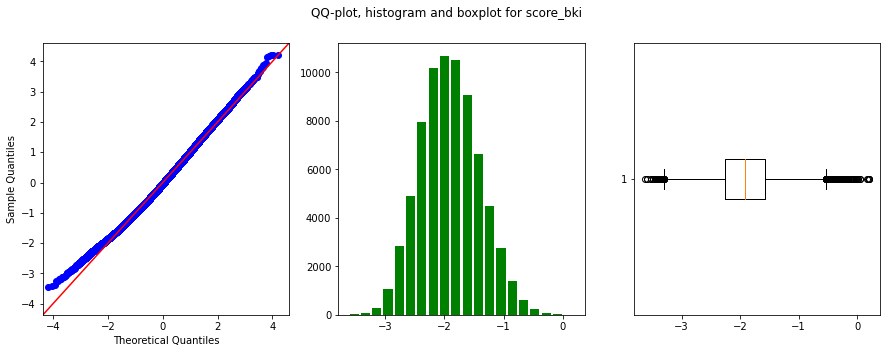

In [62]:
data_score_bki.show_plots()

Распределение, очевидно, нормальное, не смещенное. Однако, есть выбросы.

In [63]:
print('Суммарное количество выбросов для score_bki: ', NumFitInspect(data[data.Train == 1], 'score_bki').outliers())

Суммарное количество выбросов для score_bki:  351


***Заключение по score_bki*** : распределение нормальное, не смещенное, логарифм брать не надо, выбросов относительно не много, не будем их удалять. Создали новый признак score_bki_abslog

#### 4.3.6. app_cnt

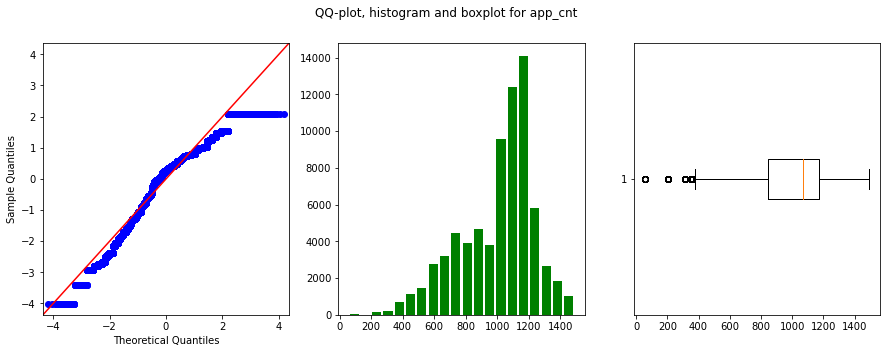

In [64]:
# Построим графики для app_cnt
NumFitInspect(data[data.Train == 1], 'app_cnt').show_plots()

In [65]:
print('Суммарное количество выбросов для score_bki: ', NumFitInspect(data[data.Train == 1], 'app_cnt').outliers())

Суммарное количество выбросов для score_bki:  844


***Заключение по app_cnt*** : распределение нормальное, немного смещенное, логарифм брать не надо, выбросов относительно не много, не будем их удалять.

Построим матрицу корреляции для числовых признаков num_cols

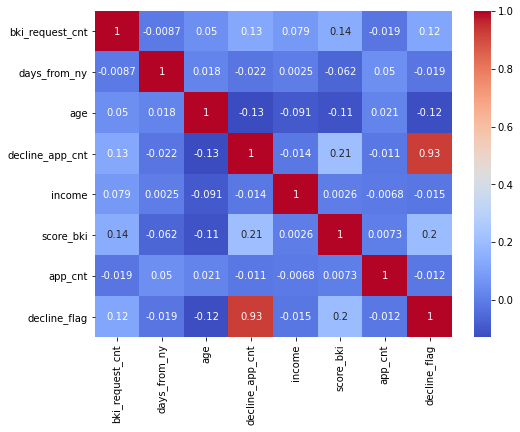

In [66]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data.loc[:,num_cols + new_fits].corr(),annot = True, cmap = 'coolwarm')


Очевидно, что новый признак зависит от того, на основании которого был создан. Тем не менее, проверим, как на нем работает модель. <br>
Посмотрим на значимость признаков для default

Значимость непрерывных переменных (на основе однофакторного дисперсионного анализа (ANOVA))
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости мы будем использовать значение f -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

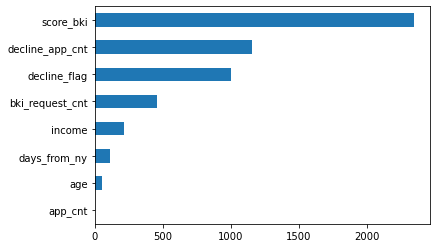

In [67]:
imp_num = pd.Series(f_classif(data[data.Train == 1][num_cols+new_fits], data[data.Train == 1]['default'])[0], index = num_cols+new_fits)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Новый признак decline_flag менее значим, чем исходный decline_app_cnt, не будем его использовать.

- наиболее значимый признак - score_bki;
- наименее значимый - age и app_cnt

Посмотрим, как распределены категориальные признаки относительно числовых

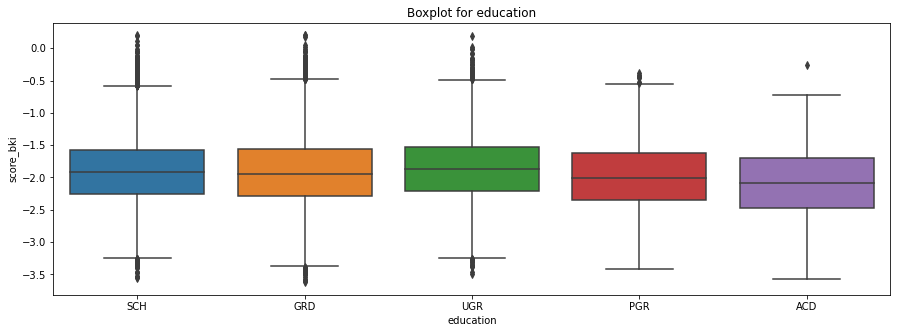

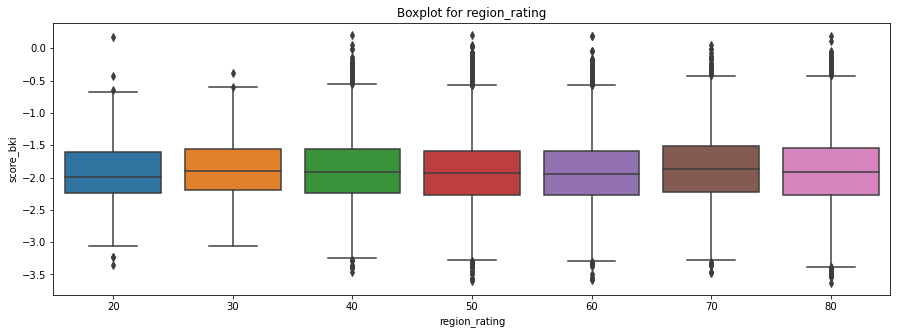

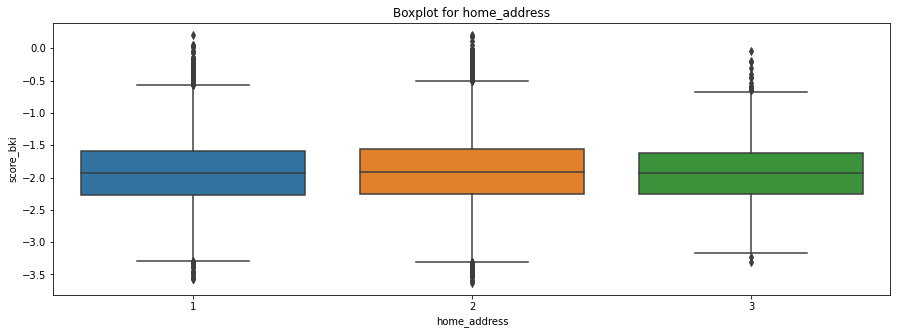

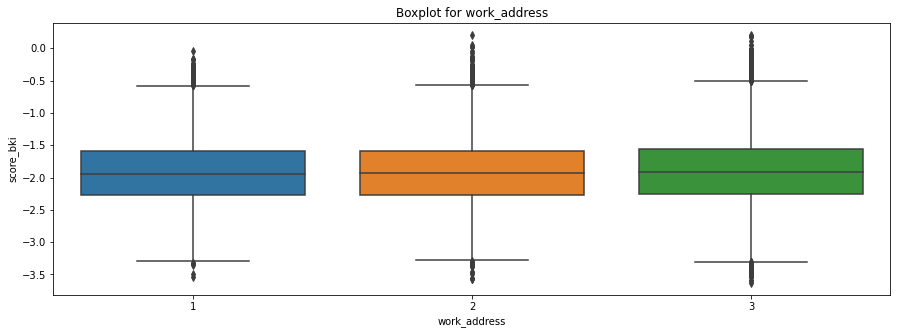

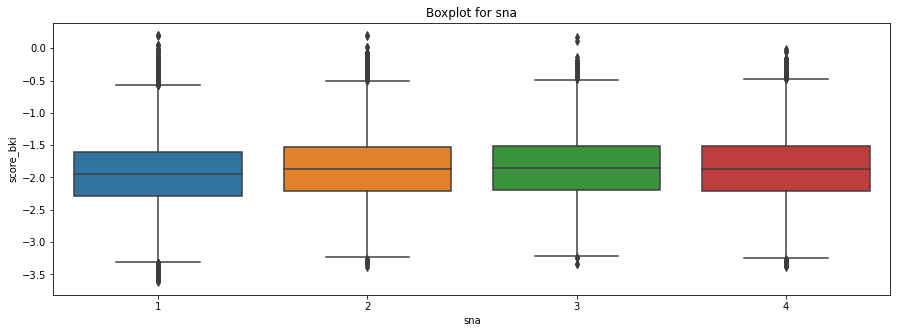

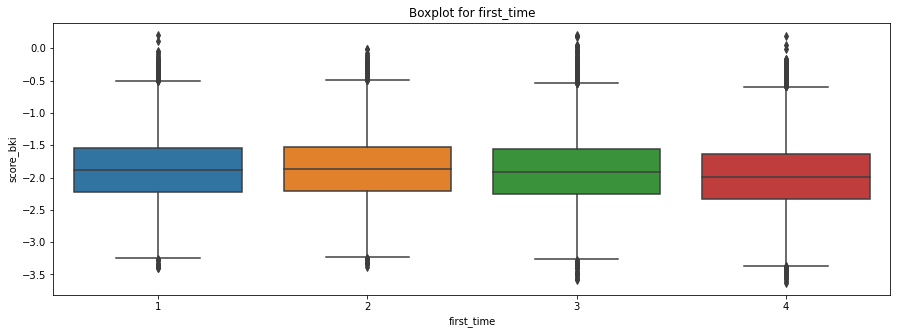

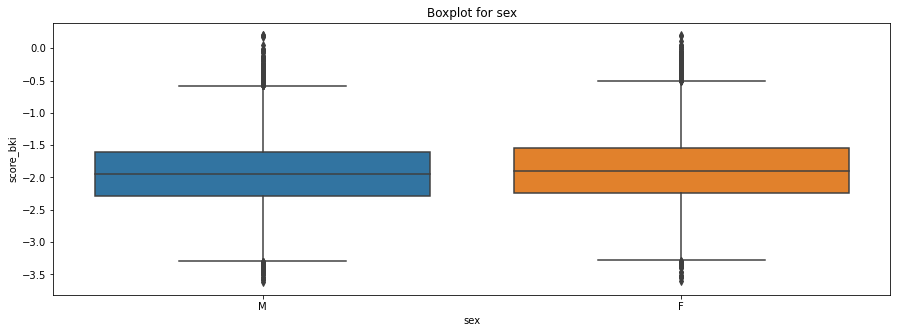

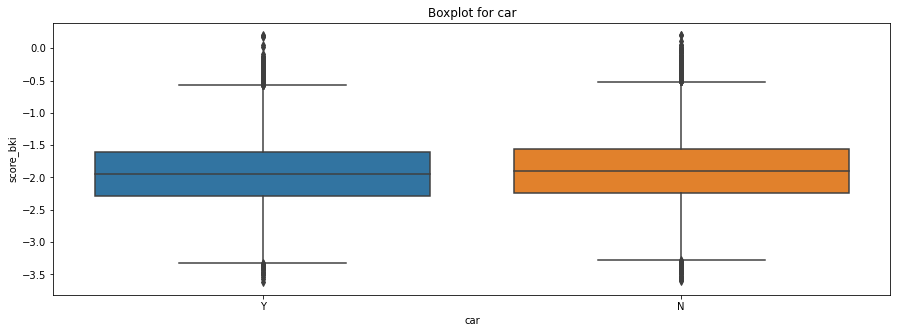

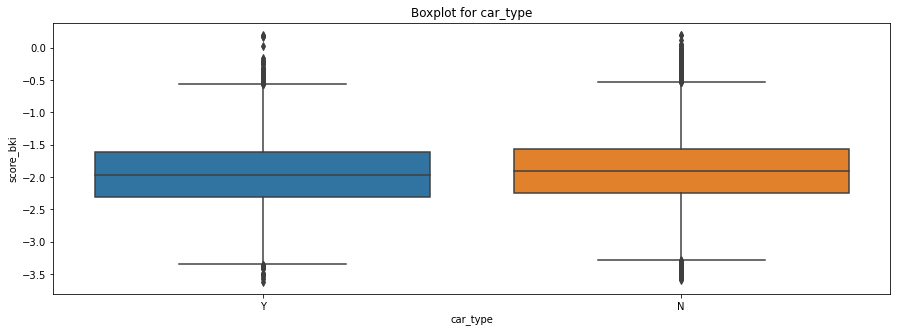

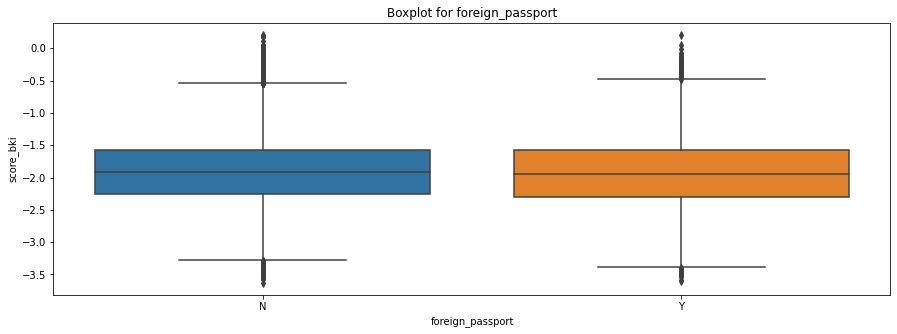

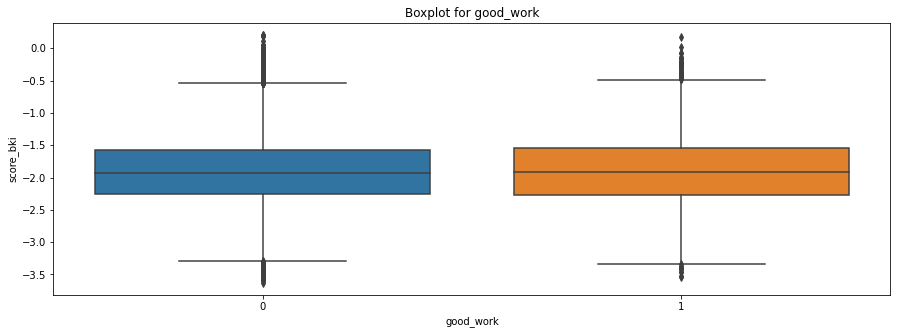

In [68]:
for col in cat_cols + bin_cols:
    fig, ax = plt.subplots(1, 1, figsize = (15, 5))
    sns.boxplot(x = col, y='score_bki', data = data, ax=ax)
    ax.set_title('Boxplot for {0}'.format(col))
    plt.show()

В разрезе всех категорий числовые признаки распределены крайне не равномерно. Обработать выбросы при помощи нормирования относительно категории не удастся.

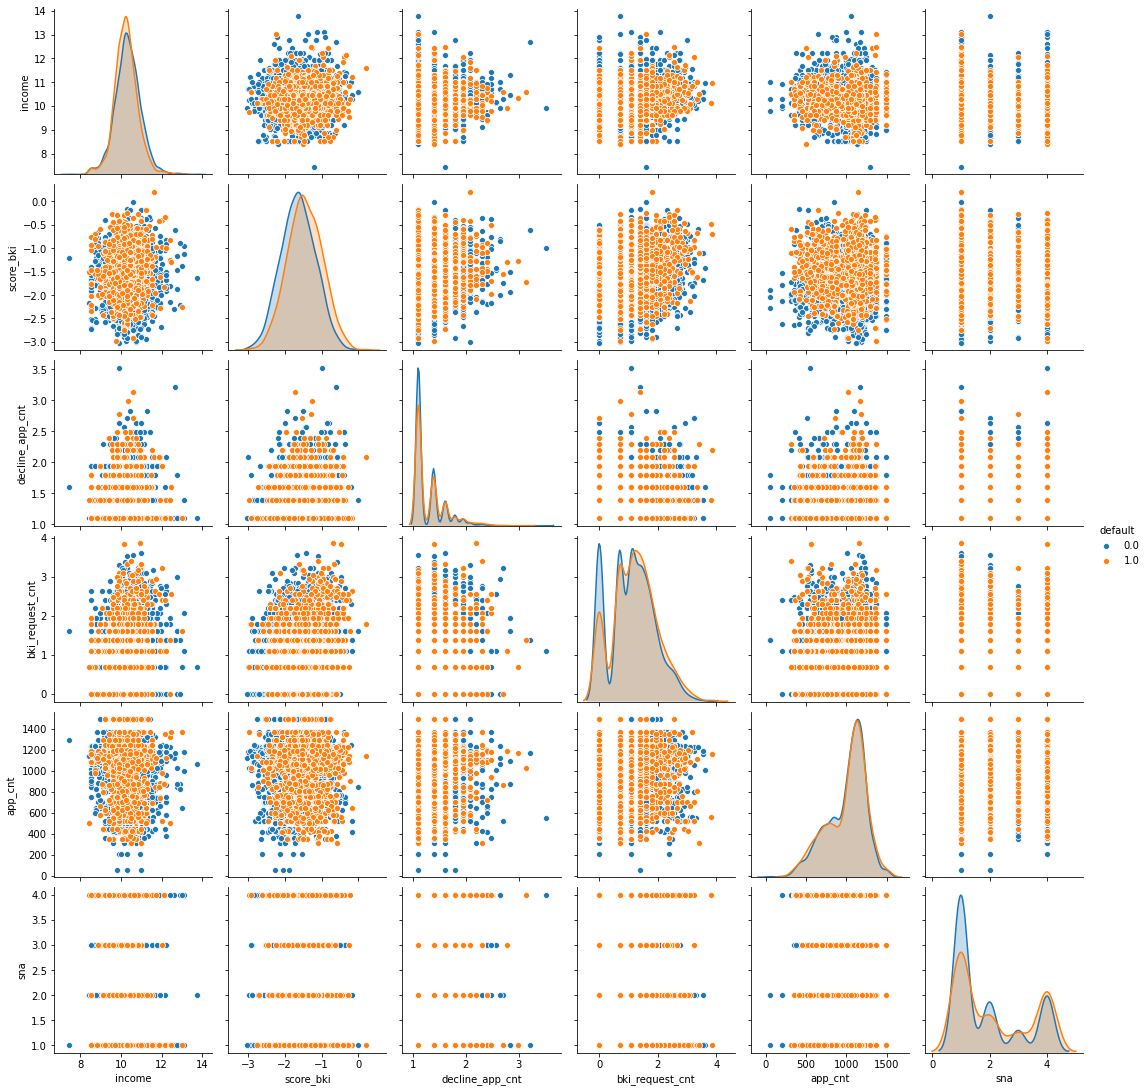

In [69]:
sns.pairplot(data[data.Train == 1 & (data.decline_app_cnt > 1)].loc[:,['income','score_bki','decline_app_cnt','bki_request_cnt','app_cnt', 'sna','default']], hue = 'default')

Дефолты и не дефолты относительно равномерно размазаны по признаками, выделить какую-то одну пару невозможно.

### 4.4. Обработаем категориальные и бинарные признаки

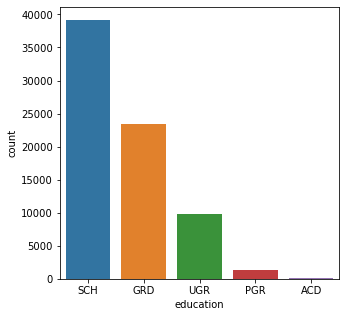

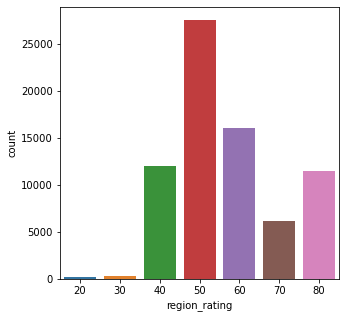

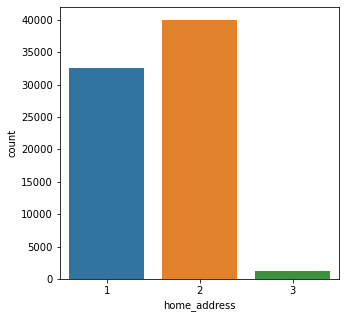

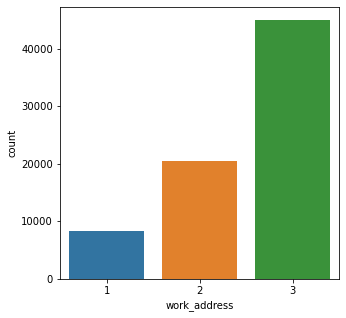

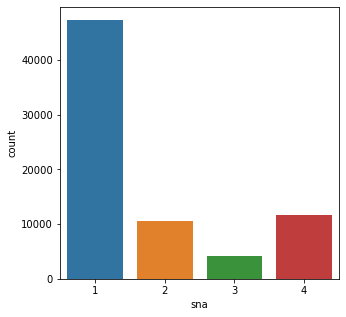

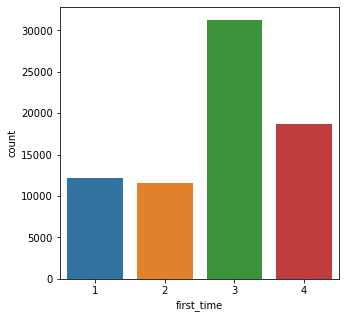

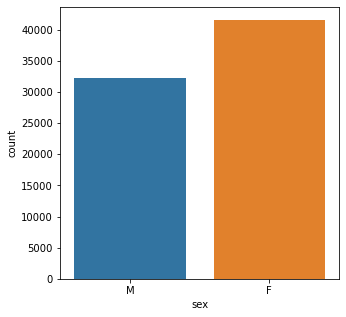

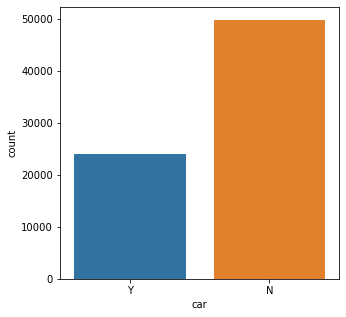

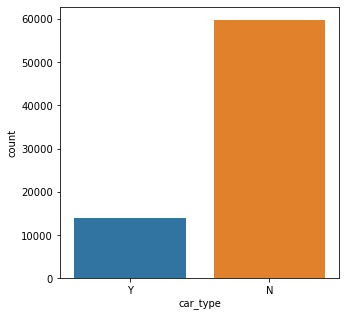

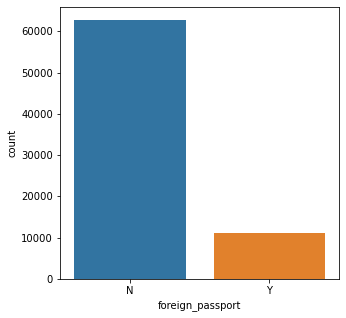

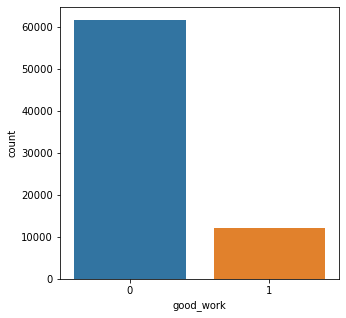

In [70]:
for i, col in enumerate(cat_cols + bin_cols):
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    sns.countplot(x=col, data=data[data.Train == 1], ax = ax)

Закодируем категориальные признаки education и region_rating и бинарные признаки

In [71]:
# Преобразуем education в целочисленный формат
label_encoder = LabelEncoder()
data['education'] = label_encoder.fit_transform(data['education'])
data.education.unique()

array([3, 1, 4, 2, 0])

In [72]:
# Закодируем region_rating
label_encoder = LabelEncoder()
data['region_rating'] = label_encoder.fit_transform(data['region_rating'])
data.region_rating.unique()

array([3, 6, 4, 2, 5, 0, 1])

In [73]:
# Преобразуем биноминальные признаки
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])
    
# убедимся в преобразовании    
data.head(5)

education  sex       age  car  car_type  decline_app_cnt  good_work  \
0          3    1  4.143135    1         1         0.000000          0   
1          3    0  4.094345    0         0         0.000000          0   
2          3    1  3.258097    1         0         1.098612          0   
3          3    0  3.988984    0         0         0.000000          0   
4          1    1  3.891820    0         0         0.000000          1   

   score_bki  bki_request_cnt  region_rating  ...  work_address     income  \
0  -2.008753         0.693147              3  ...             2   9.798183   
1  -1.532276         1.386294              3  ...             3   9.852247   
2  -1.408142         0.693147              6  ...             2  10.308986   
3  -2.057471         1.098612              3  ...             3   9.210440   
4  -1.244723         0.693147              4  ...             3  10.308986   

   sna  first_time  foreign_passport  default  Train  days_from_ny  app_cnt  \
0    4           1                 0      0.0      1            31      794   
1    4           1                 0      0.0      1            70     1110   
2    1           4                 1      0.0      1            31      794   
3    1           3                 0      0.0      1            22     1060   
4    1           4                 1      0.0      1           107      981   

   decline_flag  
0             0  
1             0  
2             1  
3             0  
4             0  

[5 rows x 21 columns]

In [74]:
# проверим
for column in bin_cols:
    print('Уникальные значения в поле {0} : {1}'.format(column,data[column].unique()))

Уникальные значения в поле sex : [1 0]
Уникальные значения в поле car : [1 0]
Уникальные значения в поле car_type : [1 0]
Уникальные значения в поле foreign_passport : [0 1]
Уникальные значения в поле good_work : [0 1]


Посмотрим на значимость категориальных признаков

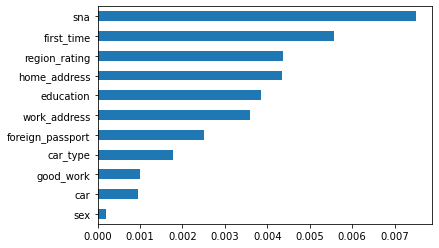

In [75]:
imp_cat = pd.Series(mutual_info_classif(data[data.Train == 1][bin_cols + cat_cols], data[data.Train == 1]['default'], 
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

- cамый значимый признак - sna;
- наименее значимый признак - sex

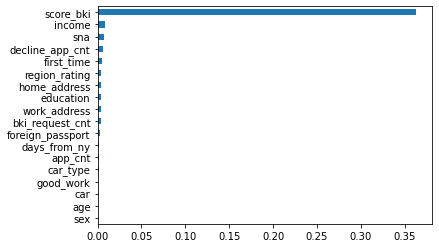

In [76]:
# посмотрим на значимость всех признаков
imp_cat = pd.Series(mutual_info_classif(data[data.Train == 1][cat_cols+bin_cols+num_cols], data[data.Train == 1]['default'], 
                                     discrete_features =True), index = cat_cols+bin_cols+num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самые значимые признаки: score_bki, income, sna. <br>
Наимение значимые: age и sex. <br>
Что представляется вполне логичным.

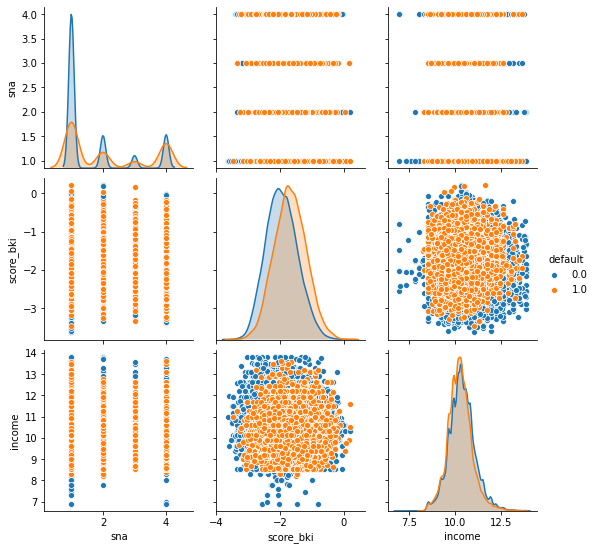

In [77]:
# попробуем обнаружить "разделяюющую поверхность"
sns.pairplot(data[data.Train == 1].loc[:,['sna', 'score_bki','income', 'default']], hue = 'default')


Посмотрим в объеме. Может там удастся "увидеть разделяющую поверхность"

In [78]:
import plotly.express as px

fig = px.scatter_3d(data[data.Train == 1], x='score_bki', y='income', z='sna', color='default')
fig.show()

Красивой разделяющей поверхности (даже криволинейной) не наблюдается. Очевидно, качество предсказания логистической регрессии будет не очень высокое.

# 5. Подготовим данные к ML

In [79]:
# закодируем категориальные признаки при помощи get_dummy
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns = cat_cols)
data_cat.sample(3)

education_0  education_1  education_2  education_3  education_4  \
100026            0            0            0            0            1   
8005              0            0            0            1            0   
68390             0            1            0            0            0   

        region_rating_0  region_rating_1  region_rating_2  region_rating_3  \
100026                0                0                0                1   
8005                  0                0                0                0   
68390                 0                0                0                0   

        region_rating_4  ...  work_address_2  work_address_3  sna_1  sna_2  \
100026                0  ...               1               0      0      1   
8005                  1  ...               1               0      1      0   
68390                 1  ...               0               1      1      0   

        sna_3  sna_4  first_time_1  first_time_2  first_time_3  first_time_4  
100026      0      0             1             0             0             0  
8005        0      0             0             0             1             0  
68390       0      0             1             0             0             0  

[3 rows x 26 columns]

In [80]:
len(num_cols + cat_cols + bin_cols)

18

In [81]:
# стандартизиуем числовые признаки
data_num = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = num_cols)

In [82]:
# объединим все признаки в один датасет

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)
#X = pd.concat([data_num, data['Train'], data['default']], axis = 1)

Y = data['default'].values

In [83]:
# проверим столбцы X
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   bki_request_cnt   110148 non-null  float64
 1   days_from_ny      110148 non-null  float64
 2   age               110148 non-null  float64
 3   decline_app_cnt   110148 non-null  float64
 4   income            110148 non-null  float64
 5   score_bki         110148 non-null  float64
 6   app_cnt           110148 non-null  float64
 7   education_0       110148 non-null  uint8  
 8   education_1       110148 non-null  uint8  
 9   education_2       110148 non-null  uint8  
 10  education_3       110148 non-null  uint8  
 11  education_4       110148 non-null  uint8  
 12  region_rating_0   110148 non-null  uint8  
 13  region_rating_1   110148 non-null  uint8  
 14  region_rating_2   110148 non-null  uint8  
 15  region_rating_3   110148 non-null  uint8  
 16  region_rating_4   11

In [84]:
# Проверим образец из трех строк
X.sample(3)

bki_request_cnt  days_from_ny       age  decline_app_cnt    income  \
65185        -0.281790     -1.027919 -1.390791         1.499512 -0.052834   
47510         0.770563      0.530882 -0.773745        -0.418815 -0.634846   
94064        -0.281790     -0.716159  0.207072         3.417839 -0.314543   

       score_bki   app_cnt  education_0  education_1  education_2  ...  \
65185   0.673944  0.771365            0            0            0  ...   
47510   0.393238  0.775621            0            0            0  ...   
94064  -0.082720 -1.514145            0            0            0  ...   

       first_time_2  first_time_3  first_time_4  sex  car  car_type  \
65185             0             0             0    1    0         0   
47510             0             0             1    0    0         0   
94064             0             0             0    0    0         0   

       foreign_passport  good_work  Train  default  
65185                 0          0      1      0.0  
47510                 0          0      1      0.0  
94064                 0          0      0      NaN  

[3 rows x 40 columns]

In [85]:
print(cat_cols + bin_cols)

['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'sex', 'car', 'car_type', 'foreign_passport', 'good_work']


# 6. Построим модель

#### Разобьем датасет на тренировочный и тестовый

Сперва обработаем выбросы:

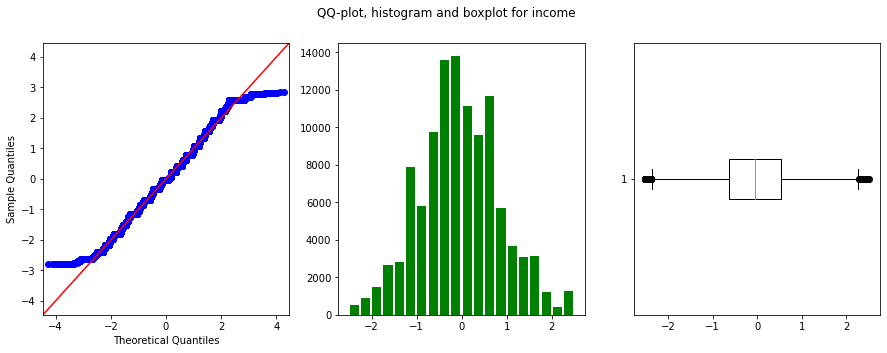

In [86]:
col = 'income'
minb, maxb = NumFitInspect(X.loc[:, [col]], col).boundaries()
mean = X[col].mean()
X[col] = X[col].apply(lambda x : x if ((x >= minb) & (x <= maxb)) else mean)
NumFitInspect(X.loc[:, [col]], col).show_plots()

In [87]:
train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

#### Выделим из тренировочного датасета 20% на валидацию

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### Проверим

In [89]:
print(X.shape, X_train.shape, X_test.shape)

(73799, 38) (59039, 38) (14760, 38)


#### Обучим модель

In [90]:
warnings.simplefilter('ignore')

model = LogisticRegression(max_iter = 2000, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=42)

Посмотрим на метрики.

In [91]:
mi_1 = ModelInspect(model, X_test, y_test)

#### Построим ROC-кривую

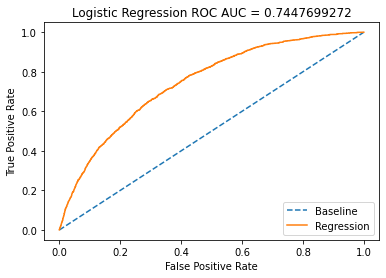

In [92]:
mi_1.roc_curve_plot()

Метрика ROC_AUC - достаточно велика, то есть даже без глубокого отбора и конструирования признаков нам удалось построить модель, чья предсказательная сила заметно отличается от случайного угадывания.

#### Однако посмотрим на качественные метрики

In [93]:
mi_1.get_metrics()

accuracy     0.874661
precision    0.388350
recall       0.021894
F1           0.041451
ROC_AUC      0.744770
dtype: float64

Confusion matrix

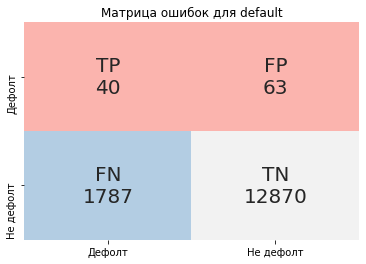

In [94]:
mi_1.confusion_matrix_plot()

Кривая зависимости precision от recall

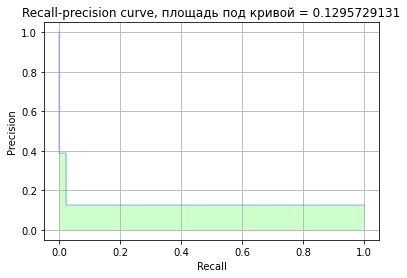

In [95]:
mi_1.recall_precision_plot()

***Заключение по модели без регуляризации:*** не смотря на то, что значения ROC_AUC и accuracy достаточно высоки, значения recall и F1 показывают, что предсказательная способность низкая, ошибка второго рода (ложно отрицательные, дефолт классифицирован как не-дефолт) очень высока. Это означает, что при использовании такой модели банк может понести большие убытки. <br>
Попробуем:
- сбалансировать модель;
- применить регуляризацию.

# 7. Разберемся со сбалансированностью default

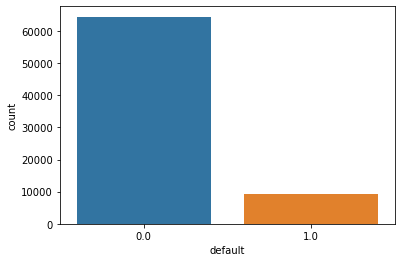

In [96]:
ax = sns.countplot(x="default", data=data)

In [97]:
print('класс 0: ', len(y_train[y_train == 0]))
print('класс 1: ', len(y_train[y_train == 1]))
print('веса классов: w0 = {0}, w1 = {1}'.format(round(len(Y[Y == 0])/len(Y[Y == 1])), 1))

класс 0:  51494
класс 1:  7545
веса классов: w0 = 7, w1 = 1


In [98]:
np.bincount(y_train.flatten().astype(int))

array([51494,  7545])

Выборка сильно не сбалансирована. <br>
Для сглаживания влияния несбалансированности применим параметр модели
- class_weight = 'balanced' - параметр для балансировки классов


In [99]:
model = LogisticRegression(class_weight='balanced', max_iter = 2000, random_state = RANDOM_SEED)
model.fit(X_train, y_train)
mi_balanced = ModelInspect(model, X_test, y_test)

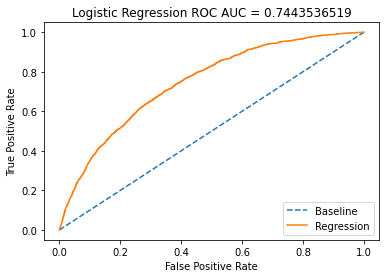

In [100]:
mi_balanced.roc_curve_plot()

In [101]:
mi_balanced.get_metrics()

accuracy     0.670596
precision    0.225836
recall       0.684182
F1           0.339582
ROC_AUC      0.744354
dtype: float64

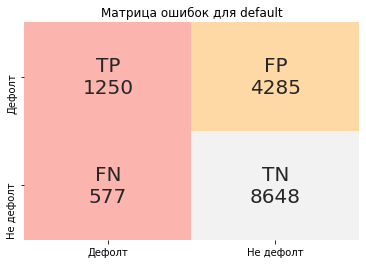

In [102]:
mi_balanced.confusion_matrix_plot()

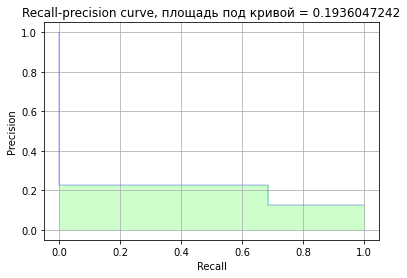

In [103]:
mi_balanced.recall_precision_plot()

Мы видим, что после применения параметра балансировки, ошибка второго рода уменьшилась, метрики recall и f1 очень возрасли, это означает, что предсказание можели улучшилось. Однако очень сильно возрасла ошибка первого рода (не-дефолт классифицирован как дефолт). Это означает, что при применении такой модели банк рискует недополучить прибыль. Нужно найти золотую середину.

# 7.1. Проверим нулевые коэффициенты

При помощи l1 регуляризации проверим нулевые коэффициенты.

In [104]:
model = LogisticRegression(random_state = RANDOM_SEED, 
                           C = 1, 
                           class_weight = 'balanced', 
                           penalty = 'l1', 
                           solver = 'liblinear',
                           max_iter = 2000,
                           )

model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=2000, penalty='l1',
                   random_state=42, solver='liblinear')

In [105]:
df_coef = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(38,1), model.coef_.reshape(38,1))), columns = ['col', 'coef'])

In [106]:
df_coef['abs_coef'] = np.abs(df_coef.coef)
df_coef.sort_values(['abs_coef'], ascending = False)

col        coef    abs_coef
18   region_rating_6   -0.842236    0.842236
7        education_0   -0.626686    0.626686
12   region_rating_0    0.584112    0.584112
17   region_rating_5   -0.515562    0.515562
5          score_bki    0.485491    0.485491
13   region_rating_1    0.465066    0.465066
9        education_2    -0.37515     0.37515
22    work_address_1   -0.347985    0.347985
33               sex    0.296283    0.296283
25             sna_1   -0.291326    0.291326
19    home_address_1   -0.284754    0.284754
10       education_3    0.282247    0.282247
32      first_time_4   -0.280892    0.280892
14   region_rating_2     0.27113     0.27113
35          car_type   -0.270927    0.270927
20    home_address_2    0.249243    0.249243
36  foreign_passport    -0.22103     0.22103
21    home_address_3   -0.204372    0.204372
37         good_work   -0.194563    0.194563
0    bki_request_cnt     0.18845     0.18845
28             sna_4    0.179293    0.179293
3    decline_app_cnt    0.148756    0.148756
1       days_from_ny   -0.141536    0.141536
11       education_4     0.13684     0.13684
8        education_1   -0.117082    0.117082
16   region_rating_4   -0.106653    0.106653
31      first_time_3   -0.104453    0.104453
30      first_time_2   0.0803726   0.0803726
27             sna_3  -0.0658062   0.0658062
24    work_address_3   0.0560593   0.0560593
23    work_address_2  -0.0494099   0.0494099
4             income  -0.0336846   0.0336846
2                age  -0.0333592   0.0333592
6            app_cnt   0.0267737   0.0267737
34               car -0.00392318  0.00392318
15   region_rating_3           0           0
26             sna_2           0           0
29      first_time_1           0           0

In [107]:
list(np.array(df_coef[df_coef.coef == 0].col))

['region_rating_3', 'sna_2', 'first_time_1']

Нулевые коэффициенты означают, что признаки 'region_rating_3', 'sna_2', 'first_time_1' "не нравятся" модели, их вполне можно отбросить.

In [108]:
cols_4del = list(np.array(df_coef[df_coef.coef == 0].col))
cols_4del

['region_rating_3', 'sna_2', 'first_time_1']

In [109]:
X_train.drop(cols_4del, axis = 1, inplace = True)
X_test.drop(cols_4del, axis = 1, inplace = True)

Проверим модель:

In [110]:
model = LogisticRegression(max_iter = 2000, class_weight='balanced', random_state = RANDOM_SEED)
model.fit(X_train, y_train)
mi_drop0coef = ModelInspect(model, X_test, y_test)

In [111]:
pd.concat([mi_balanced.get_metrics(),mi_drop0coef.get_metrics()], axis = 1)

0         1
accuracy   0.670596  0.670596
precision  0.225836  0.225836
recall     0.684182  0.684182
F1         0.339582  0.339582
ROC_AUC    0.744354  0.744354

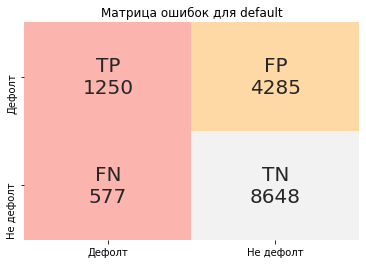

In [112]:
mi_drop0coef.confusion_matrix_plot()

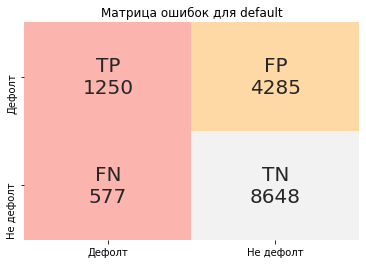

In [113]:
mi_balanced.confusion_matrix_plot()

По матрице ошибок видим, что предсказание модели после удаления нулевых признаков не изменилось.

In [114]:
np.logspace(-2, 0, 20)

array([0.01      , 0.01274275, 0.01623777, 0.02069138, 0.02636651,
       0.03359818, 0.04281332, 0.05455595, 0.06951928, 0.08858668,
       0.11288379, 0.14384499, 0.18329807, 0.23357215, 0.29763514,
       0.37926902, 0.48329302, 0.61584821, 0.78475997, 1.        ])

# 8. Подберем параметры модели

In [115]:
C = np.logspace(-1, 3, 10)
iter_ = 1000
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [116]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# указываем модель (в нашем случае лог регрессия), гиперпараметры
model = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_SEED)

In [117]:
# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

Лучшие значения параметров:
  C = 0.2782559402207124,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 1000,
  multi_class = auto,
  n_jobs = None,
  penalty = l2,
  random_state = 42,
  solver = saga,
  tol = 0.001,
  verbose = 0,
  warm_start = False,


Я довольно долго играла с подбором параметра: от слабой регуляризации с С>50 до очень сильной c C < 1. <br>
Решила остановиться на С = 0,278. Но есть риск переобучения при такой сильной регуляризации, поэтому сделаем кросс-валидацию. 

In [118]:
mi_bestparams = ModelInspect(model_best_params, X_test, y_test)

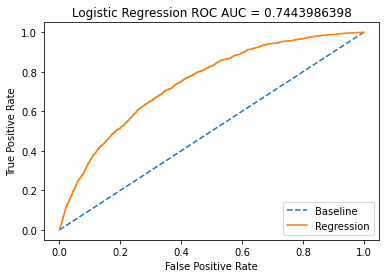

In [119]:
mi_bestparams.roc_curve_plot()

In [120]:
metrics = pd.concat([mi_drop0coef.get_metrics(), mi_bestparams.get_metrics()],axis = 1)
metrics.columns = ['last iter', 'best params']
metrics

last iter  best params
accuracy    0.670596     0.670664
precision   0.225836     0.225975
recall      0.684182     0.684729
F1          0.339582     0.339807
ROC_AUC     0.744354     0.744399

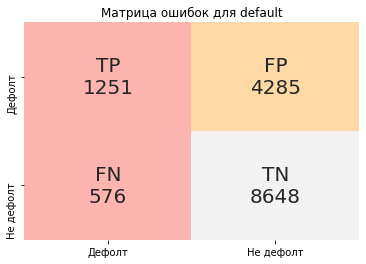

In [121]:
mi_bestparams.confusion_matrix_plot()

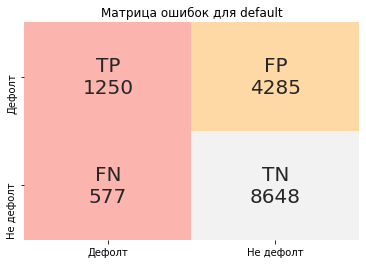

In [122]:
mi_drop0coef.confusion_matrix_plot()

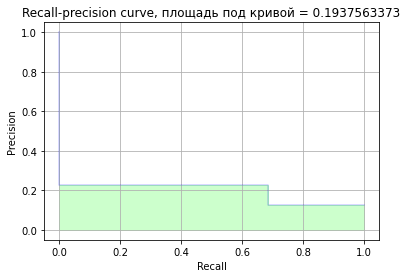

In [123]:
mi_bestparams.recall_precision_plot()

Сильная регуляризация при С = 0,278 улучшила предсказание для клиентов, которым нельзя выдавать кредит (на 1 ложно-отрицательный стало меньше). Ну, тоже результат ).
Сделаем кросс-валидацию для параметров С.

## 8.1. Кросс-валидация

Так как мы применили сильную регуляризацию, то велик риск, что наша модель переобучилась, поэтому проведем кросс-валидацию

In [124]:
# заново собирем все признаки и разобьем датасет на тренировочную и тестовые выборки

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)
Y = data['default'].values

col = 'income'
minb, maxb = NumFitInspect(X.loc[:, [col]], col).boundaries()
mean = X[col].mean()
X[col] = X[col].apply(lambda x : x if ((x >= minb) & (x <= maxb)) else mean)

train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.drop(cols_4del, axis = 1, inplace = True)
X_test.drop(cols_4del, axis = 1, inplace = True)

In [125]:
X.drop(cols_4del, axis = 1, inplace = True)

In [126]:
# обучим модели с подобранными параметрами

# без регуляризации
model0 = LogisticRegression(
  C = 1,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False
)

In [127]:
model1 = LogisticRegression(
C = 0.021544346900318832,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False
)

In [128]:
# испортируем библиотеку для kfold кросс-валидации 
from sklearn.model_selection import cross_val_score

In [129]:
# посчитаем метрику F1 для 10 фолдов.
scores0 = cross_val_score(model0, X, y, cv=10, scoring='f1')
scores1 = cross_val_score(model1, X, y, cv=10, scoring='f1')

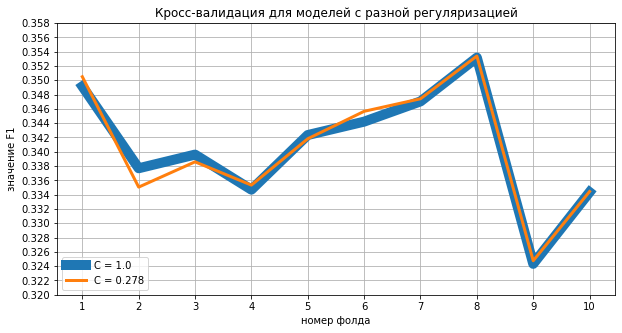

In [130]:
x = np.arange(1,11)

fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.plot(x, scores0, label = 'C = 1.0', linewidth=10)
plt.plot(x, scores1, label = 'C = 0.278', linewidth=3)
plt.legend(loc = 'lower left')
plt.title('Кросс-валидация для моделей с разной регуляризацией')
plt.ylabel('значение F1')
plt.xlabel('номер фолда')
ax.set_xticks(x)
yticks = np.arange(0.32, 0.36, 0.002)
ax.set_yticks(yticks)
ax.grid(True)

Гипотеза о переобучении не подтвердилась. Регуляризация никак не повлияла на предсказание. Однако AUC подрос. Оставим для сэмпла С = 0.278. При нем получается максимальный AUC на сэмпле, а у нас все-таки соревнование ).

## 8.2. LogisticRegressionCV

Попробуем применить LogisticRegressionCV для подбора оптимальных параметорв.

In [131]:
# заново собирем все признаки и разобьем датасет на тренировочную и тестовые выборки

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)
Y = data['default'].values
#X.drop(['app_cnt'], axis = 1, inplace = True)


#col = 'income'
#minb, maxb = NumFitInspect(X.loc[:, [col]], col).boundaries()
#mean = X[col].mean()
#X[col] = X[col].apply(lambda x : x if ((x >= minb) & (x <= maxb)) else mean)

train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#X_train.drop(cols_4del, axis = 1, inplace = True)
#X_test.drop(cols_4del, axis = 1, inplace = True)

In [132]:
#Cs_ = np.linspace(0.005, 0.006, 100)
Cs_ = np.logspace(-4, 4, 100)

In [133]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  class_weight = 'balanced',
  n_jobs = -1,
  random_state = 42,
)

model.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                     class_weight='balanced', cv=5, max_iter=1000, n_jobs=-1,
                     random_state=42, scoring='f1', solver='saga')

In [134]:
model.C_

array([0.00599484])

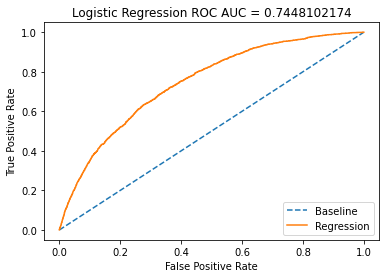

In [135]:
mi_CV = ModelInspect(model, X_test, y_test)
mi_CV.roc_curve_plot()

In [136]:
metrics = pd.concat([mi_bestparams.get_metrics(), mi_CV.get_metrics(), ],axis = 1)
metrics.columns = ['best params', 'CV']
metrics

best params        CV
accuracy      0.670664  0.672087
precision     0.225975  0.227232
recall        0.684729  0.686918
F1            0.339807  0.341497
ROC_AUC       0.744399  0.744810

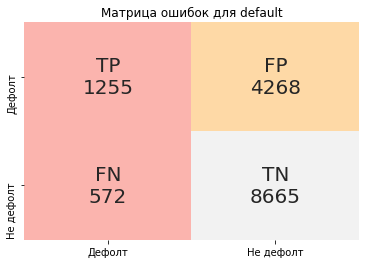

In [137]:
mi_CV.confusion_matrix_plot()

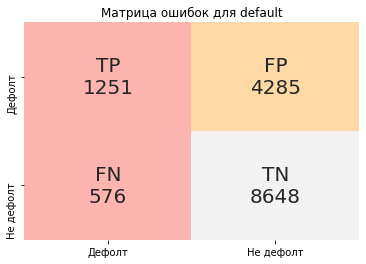

In [138]:
mi_bestparams.confusion_matrix_plot()

Применение LogisticRegressionCV улучшило предсказание модели: количество ложно-положительных (отказов) уменьшилось на 14, а ложно-отрицательных на 4.

# 8.3. Попробуем подобрать признаки, которые дают наилучшее значение f1

In [139]:
# заново собирем все признаки и разобьем датасет на тренировочную и тестовые выборки

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)
Y = data['default'].values

train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [140]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS # импортируем библиотеку для подбора признаков

In [141]:
'''
# На модели model = LogisticRegressionCV из предыдущего шага 
sfs = SFS(estimator = model,        
          k_features = (1, 38),      
          scoring='f1', 
          forward = True,
          cv=5)               

# обучим модель на наших данных
sfs = sfs.fit(X_train, y_train)
'''

"\n# На модели model = LogisticRegressionCV из предыдущего шага \nsfs = SFS(estimator = model,        \n          k_features = (1, 38),      \n          scoring='f1', \n          forward = True,\n          cv=5)               \n\n# обучим модель на наших данных\nsfs = sfs.fit(X_train, y_train)\n"

In [142]:
'''
print('Лучший F1 score: %.2f' % sfs.k_score_)   
print('Количество лучших признаков:', len(sfs.k_feature_idx_))                                                    
print('Лучшие признаки:', sfs.k_feature_names_) 
'''

"\nprint('Лучший F1 score: %.2f' % sfs.k_score_)   \nprint('Количество лучших признаков:', len(sfs.k_feature_idx_))                                                    \nprint('Лучшие признаки:', sfs.k_feature_names_) \n"

Флаг наличия загран-паспорта SFS не понравился. Эксперимент на сэмпле улучшения не показал.

# 9. Вывод
- Благодаря подбору параметров модели удалось улучшить recall в ~ 20 раз. <br>
- Ошибка второго рода уменьшилась, мы лучше стали определять дефолтных клиентов, однако очень сильно возрасла ошибка первого рода (не-дефолт классифицирован как дефолт). Это означает, что при применении такой модели банк рискует недополучить прибыль.
- Precision и F1 также увеличились. <br>
- Тем не менее, на метрику AUC подбор параметров особо не повлиял, очевидно, для несбалансированной выборки эта метрика не показательная. 

# Submission

In [143]:
# заново собирем все признаки и разобьем датасет на тренировочную и тестовые выборки

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)
Y = data['default'].values

train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

In [144]:
model = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  class_weight = 'balanced',
  n_jobs = -1,
  random_state = 42,
)

model.fit(X, y)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                     class_weight='balanced', cv=5, max_iter=1000, n_jobs=-1,
                     random_state=42, scoring='f1', solver='saga')

In [145]:
#model = LogisticRegression()
#model.fit(X, y)

In [146]:
X_test = test_data.drop(['default'], axis=1)
y_pred_prob = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

# 10. Попробуем выполнить undersampling

Попробуем решить проблему несбалансированных данных (default = 0 в разы больше, чем default = 1) при помощи метода undersampling — уменьшение кол-ва объектов класса-большинства

Будем использовать для этого библиотеку imbalanced-learn

In [147]:
from imblearn.under_sampling import RandomUnderSampler

In [148]:
# заново собирем все признаки и разобьем датасет на тренировочную и тестовые выборки

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)
Y = data['default'].values

train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # целевая переменная
X = train_data.drop(['default'], axis=1)

Будем использовать Synthetic Minority Oversampling Technique (SMOTE) из библиотеки imblearn

In [149]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X, y)

In [150]:
(X_us.shape, y_us.shape)

((18744, 38), (18744,))

Посмотрим как стал распределен default

In [151]:
print(len(y_us[y_us == 0]), len(y_us[y_us == 1]))

9372 9372


Мы видим, что теперь оба класса default = {0,1} распределены равномерно. <br>
Именно на этой выборке обучим модель.

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=RANDOM_SEED)

Обучим модель и посмотрим на метрики.

In [153]:
model_us = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  n_jobs = -1,
  random_state = 42,
)

model_us.fit(X_train, y_train)
mi_us = ModelInspect(model_us, X_test, y_test)

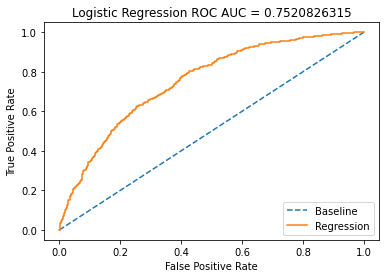

In [154]:
mi_us.roc_curve_plot()

In [155]:
mi_us.get_metrics()

accuracy     0.677333
precision    0.681296
recall       0.684874
F1           0.683080
ROC_AUC      0.752083
dtype: float64

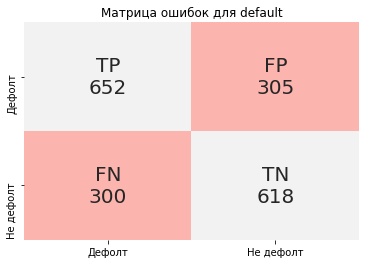

In [156]:
mi_us.confusion_matrix_plot()

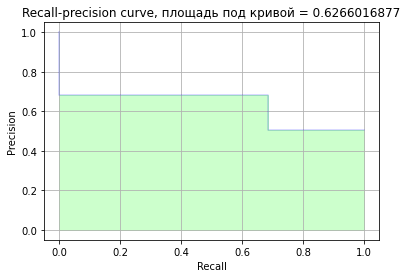

In [157]:
mi_us.recall_precision_plot()

На undersampling датасете значения метрик очень высокие. Мы увидели, как важна сбалансированность признаков и насколько сильно это влияет на качество модели.

Посмотрим, какие значения получим на тестовых данных

### Submission

In [158]:
model_us = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  n_jobs = -1,
  random_state = 42,
)

model_us.fit(X_us, y_us)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                     cv=5, max_iter=1000, n_jobs=-1, random_state=42,
                     scoring='f1', solver='saga')

In [159]:
model_us.C_

array([0.02205131])

In [160]:
X_test = test_data.drop(['default'], axis=1)

y_pred_prob = model_us.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob


In [161]:
submit.to_csv('submission_us.csv', index=False)

На сэмпле модель также показала хороший результат. Вывод: метод Undersampling работает ))